In [1]:
import boto3
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sagemaker import KMeans, get_execution_role
import seaborn as sns


sns.set_theme(style="darkgrid")
%matplotlib inline

In [2]:
!pip -q install geopandas 
import geopandas

In [3]:
!pip install --upgrade pip --quiet
!pip install mxnet --quiet
import mxnet as mx

In [4]:
data = pd.read_csv('ufo_fullset.csv', usecols=['latitude', 'longitude', 'researchOutcome'])
explained = data[data.researchOutcome == 'explained']
unexplained = data[data.researchOutcome == 'unexplained']
probable = data[data.researchOutcome == 'probable']

print(f"Total observations:  {data.shape[0]}")
print(f"Explained observations:  {explained.shape[0]}, {int(100*explained.shape[0]/data.shape[0])}%")
print(f"Unexplained observations:  {unexplained.shape[0]}, {int(100*unexplained.shape[0]/data.shape[0])}%")
print(f"Probable observations:  {probable.shape[0]}, {int(100*probable.shape[0]/data.shape[0])}%")


Total observations:  18000
Explained observations:  12822, 71%
Unexplained observations:  3308, 18%
Probable observations:  1870, 10%


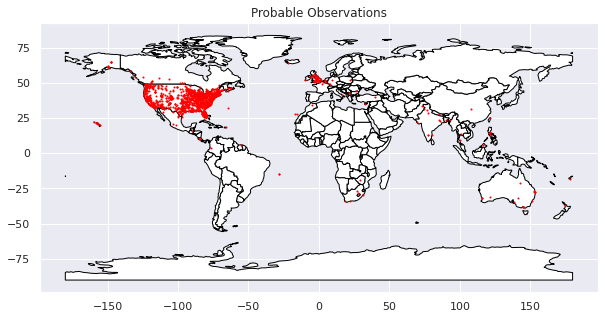

In [5]:
# locations = data[data.researchOutcome != 'explained']
locations = probable[['latitude', 'longitude']]

gdf = geopandas.GeoDataFrame(locations, geometry=geopandas.points_from_xy(locations.longitude, locations.latitude))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(color='white', edgecolor='black', figsize=(10,5))
gdf.plot(ax=ax, color='red', markersize=1)
plt.title('Probable Observations')
plt.show()

In [6]:
train_data = locations[['latitude', 'longitude']].values.astype('float32')
bucket_name = 'acg-ml-certification-df'
n_locations = 10
job_name = f'k-means-{datetime.now().strftime("%Y%m%d%H%M%S")}'

kmeans = KMeans(role=get_execution_role(),
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://' + bucket_name + '/',
                k=n_locations)
kmeans.fit(kmeans.record_set(train_data), job_name=job_name)


train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-05-28 20:48:05 Starting - Starting the training job...
2021-05-28 20:48:28 Starting - Launching requested ML instancesProfilerReport-1622234885: InProgress
......
2021-05-28 20:49:35 Starting - Preparing the instances for training............
2021-05-28 20:51:29 Downloading - Downloading input data
2021-05-28 20:51:29 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/28/2021 20:51:45 INFO 139906873169728] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_k


2021-05-28 20:51:55 Uploading - Uploading generated training model
2021-05-28 20:51:55 Completed - Training job completed
Training seconds: 40
Billable seconds: 40


#### Create Sensor GeoDataFrames 

In [7]:
model_key = job_name + '/output/model.tar.gz'
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [8]:
Kmeans_model_params = mx.ndarray.load('model_algo-1')
sensors = pd.DataFrame(Kmeans_model_params[0].asnumpy())
sensors.columns = ['latitude', 'longitude']
gdf_sensors = geopandas.GeoDataFrame(sensors, geometry=geopandas.points_from_xy(sensors.longitude, sensors.latitude))

#### Plot the Sensors and Observations

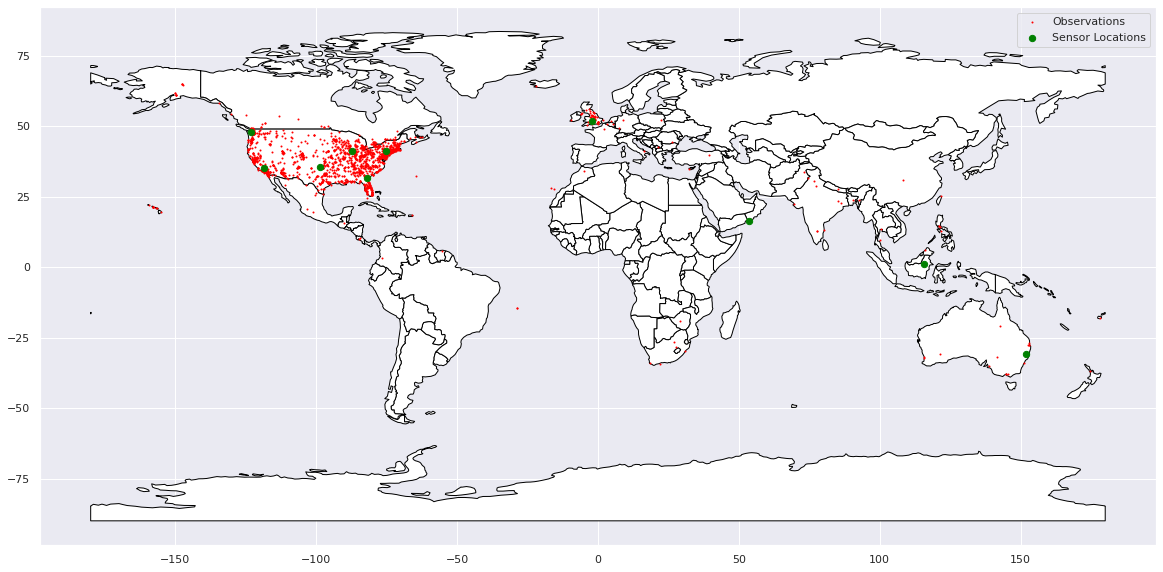

In [9]:
ax = world.plot(color='white', edgecolor='black', figsize=(20,10))
gdf.plot(ax=ax, color='red', markersize=1, label='Observations')
gdf_sensors.plot(ax=ax, color='green', markersize=40, label='Sensor Locations')
plt.legend()
plt.show()

In [11]:
file_name = 'sensors.csv'
sensors[['latitude', 'longitude']].to_csv(file_name, index=False)
s3_client = boto3.client('s3')
response = s3_client.upload_file(file_name, bucket_name, file_name)